In [1]:
from astropy.io import fits
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from csaps import csaps
from scipy.ndimage import median_filter
from astropy.stats import sigma_clip

In [2]:
from simple_veloce_reduction import veloce_reduction_tools, veloce_path

In [38]:
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(arm='green')

In [4]:
veloce_paths = veloce_path.VelocePaths('CSV_Run')

In [21]:
arm = 'green'
filename = os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_sim_calib_trace.pkl')
traces = veloce_reduction_tools.Traces.load_traces(filename)

In [6]:
def normalize_order(flux, order=4):
    smoothed_flux = median_filter(flux, 50)
    f = np.polyfit(np.arange(len(flux)),smoothed_flux,order)
    f = np.polyval(f,np.arange(len(flux)))
    flux /= f
    return flux

In [7]:
# filename = '24aug30184.fits' # use the flat because of visibility
# spectrum_filename =  os.path.join(os.getcwd(), filename)
# image_data = fits.getdata(spectrum_filename)
# image_data = remove_gaps_and_overscan_bias(image_data, overscan_range=32)
# plt.imshow(image_data, cmap='gray', norm="log")
# offset = X[0][-1]
# for x, y in zip(X, Y):
#     plt.plot(x-offset, y, c='r')
# #     print(len(x), len(y))
# plt.xlim(0,)

In [8]:
### apply this pre-made wavelength solution to ThAr calibrations and check quality

In [22]:
filename = '26aug20083.fits' # LC
# filename = '24aug30310.fits' # ThAr lamp
spectrum_filename =  os.path.join(veloce_paths.raw_dir, '230826', 'ccd_2', filename)

with fits.open(spectrum_filename) as hdul:
    image_data = hdul[0].data
    header = hdul[0].header

# plt.imshow(image_data, cmap='gray', norm="log")
image_substracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, overscan_range=32, hdr=header)

# plt.imshow(image_substracted_bias, cmap='gray', norm="log")
# extracted_ThAr_orders = veloce_reduction_tools.extract_orders_with_trace(image_substracted_bias, traces, summing_ranges)

Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01


In [10]:
%matplotlib widget

In [27]:
frame = image_substracted_bias.copy()
ylen, xlen = frame.shape
plt.imshow(frame, cmap='gray', norm='log', aspect='equal')
# y = np.arange(ylen)

for trace_y, trace_x, lower, upper in traces:
    plt.plot(trace_x+32,trace_y, c='r')
    plt.plot(trace_x,trace_y, c='b')
    # plt.plot(trace_x+upper+30,trace_y, ls=':', c='g')
    # plt.plot(trace_x-lower+30,trace_y, ls='--', c='g')
plt.xlim(0,xlen)

(0.0, 4096.0)

In [22]:

# plt.plot(extracted_ThAr_orders[6])
# plt.show()

In [23]:
# n = 1

# # for match_pix in MATCH_PIX[n-1]: ### green part needs shift by one order issue with labeling? 
# for match_pix in MATCH_PIX[n]:
#     plt.axline([match_pix+Y0[n], 0], [match_pix+Y0[n], 1], c='g')

# plt.plot(extracted_ThAr_orders[n])
# # plt.xlim(MATCH_PIX[n-1][0]-25+Y0[n],MATCH_PIX[n-1][0]+25+Y0[n])
# plt.xlim(MATCH_PIX[n][2]-25+Y0[n],MATCH_PIX[n][2]+25+Y0[n])
# # plt.xlim(2350,2400)
# plt.ylim(1000,3000)
# plt.xlabel('pix')
# plt.show()

In [55]:
plt.close('all')

In [11]:
for x in traces.x:
    if np.any(np.isnan(x)):
        print('nan')

In [28]:
traces.set_traces([(trace_y, trace_x+32) for trace_y, trace_x, _, _ in traces])

In [29]:
traces.adjust_traces(image_substracted_bias, fit_width=7)

In [30]:
traces.set_summing_range([(5,5) for _ in traces.x])

(0.0, 4096.0)

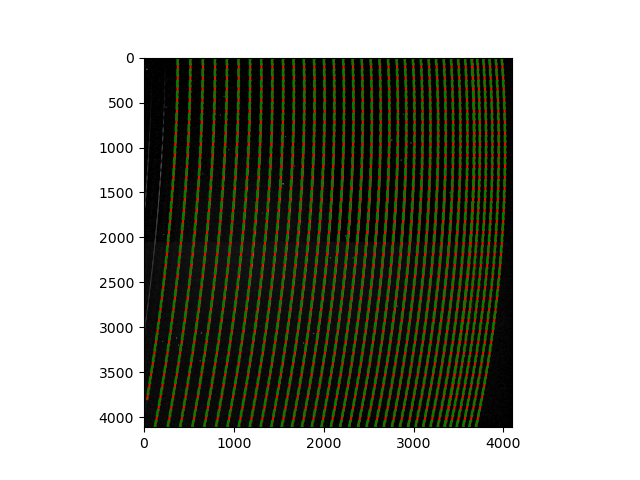

In [33]:
frame = image_substracted_bias.copy()
ylen, xlen = frame.shape
plt.imshow(frame, cmap='gray', norm='log', aspect='equal')
# y = np.arange(ylen)

for trace_y, trace_x, lower, upper in traces:
    plt.plot(trace_x,trace_y, c='r')
    plt.plot(trace_x+upper,trace_y, ls=':', c='g')
    plt.plot(trace_x-lower,trace_y, ls='--', c='g')
plt.xlim(0,xlen)

In [34]:
filename_LC = f'veloce_{arm}_LC_trace'

In [35]:
traces.save_traces(filename_LC)

In [48]:
extracted_LC, extracted_LC_imgs = veloce_reduction_tools.extract_orders_with_trace(image_substracted_bias, traces)

In [49]:
wave = veloce_reduction_tools.calibrate_orders_to_wave(extracted_LC, Y0, COEFFS, traces=traces)

In [50]:
filename = 'veloce_green_LC_'+'26aug20083.fits'
print(f'Saving {filename}')
veloce_reduction_tools.save_extracted_spectrum_fits(filename, os.getcwd(), wave, extracted_LC, header)

Saving veloce_green_LC_26aug20083.fits


'/home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/veloce_green_LC_26aug20083.fits'

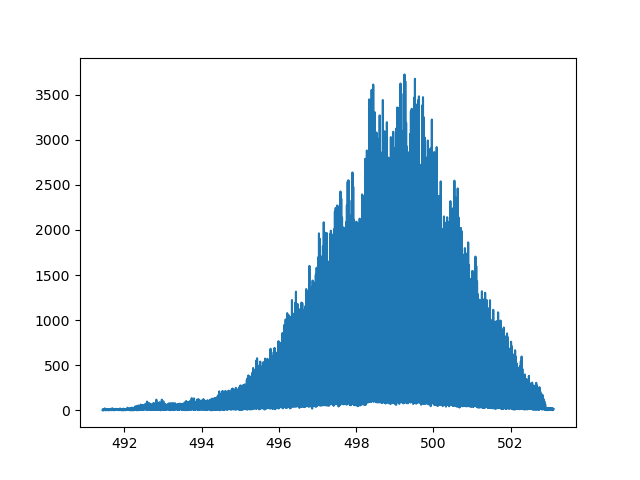

In [56]:
plt.plot(wave[20], extracted_LC[20])